# Vietnamese NLP example
Created on: 12 Septembre 2021.

In [1]:
import fastai
fastai.__version__

'2.4'

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.text.all import *
bs = 144
torch.cuda.set_device(0)

# data_path = Config.data_path()   # for fastai v1
# data_path = Path(os.getenv('FASTAI_HOME', '~/.fastai')).expanduser()  #  for fastai v2. 
# data_path = Path("./")
data_path = Config.config_path
data_path

Path('/home/wabinab/.fastai')

This will create a `viwiki` folder, containing `viwiki` text file with wikipedia contents. (For other languages, replace `vi` with appropriate code from [list of wikipedias](https://meta.wikimedia.org/wiki/List_of_Wikipedias)). 

In [72]:
lang = "vi"
# lang = "zh"

name = f"{lang}wiki"
path = data_path/name
path.mkdir(exist_ok=True, parents=True)
lm_fns = [f"{lang}_wt", f"{lang}_wt_vocab"]

In [ ]:
# # Convert traditional to simplified chinese characters
# # remember to download opencc. 
# ls *.txt | parallel -I% opencc -i % -o ../zhsdocs/% -c t2s.json

## Vietnamese Wikipedia model
### Download data

It was noticed the new `wikiextractor` doesn't have several of the functions that used to have. It might result in stub files also being downloaded. 

In [4]:
from nlputils import split_wiki, get_wiki
# get_wiki(path, lang)
# path.ls()

Indeed one already checks that it doesn't, so one have to do the thing manually after it extracts. 

In [5]:
# !head -n4 {path}/{name}

If we use curly braces, it is an actual python variable that could be use in IPython bash. Looking at the first line, it always start with `<doc...>` and it always contains the title inside this html marking. So we can split wiki into multiple text files. 

In [6]:
dest = split_wiki(path, lang)
dest.ls()[:5]

/home/wabinab/.fastai/viwiki/docs already exists; not splitting.


(#5) [Path('/home/wabinab/.fastai/viwiki/docs/Quỹ đầu tư.txt'),Path('/home/wabinab/.fastai/viwiki/docs/Voltaire.txt'),Path('/home/wabinab/.fastai/viwiki/docs/Dãy núi Ba Vì.txt'),Path('/home/wabinab/.fastai/viwiki/docs/Pakistan.txt'),Path('/home/wabinab/.fastai/viwiki/docs/Càn lăng.txt')]

# Breakpoint
For continuation of this file, we would do this on Kaggle for training purposes. 

In [7]:
get_vi = partial(get_text_files, folders=["docs"])

dls_lm = DataBlock(
    blocks=TextBlock.from_folder(path, is_lm=True),
    get_items=get_vi, splitter=RandomSplitter(0.1)
).dataloaders(path, path=path, bs=bs, seq_len=72, num_workers=os.cpu_count())

dls_lm.show_batch(max_n=2)

,text,text_
0,"xxbos xxmaj lực lượng xxmaj dân sự chiến đấu \n\n xxmaj chương trình xxmaj dân sự xxmaj chiến đấu ( tiếng xxmaj anh : "" civilian xxmaj irregular xxmaj defense xxmaj group program "" viết tắt là xxup cidg , đọc âm xxmaj việt là "" xít - gi "" ) là một chương trình được xxmaj chính phủ xxup mỹ phát triển trong xxmaj chiến tranh xxmaj việt xxmaj nam nhằm","xxmaj lực lượng xxmaj dân sự chiến đấu \n\n xxmaj chương trình xxmaj dân sự xxmaj chiến đấu ( tiếng xxmaj anh : "" civilian xxmaj irregular xxmaj defense xxmaj group program "" viết tắt là xxup cidg , đọc âm xxmaj việt là "" xít - gi "" ) là một chương trình được xxmaj chính phủ xxup mỹ phát triển trong xxmaj chiến tranh xxmaj việt xxmaj nam nhằm triển"
1,"từ lần kinh nguyệt ( lmp ) cuối cùng và việc sinh đẻ thường diễn ra trong khoảng 37 tới 42 tuần , xxmaj thời gian mang thai thực tế thường là 38 tuần sau khi thụ thai . xxup dù việc thai nghén bắt đầu khi thụ thai , để thuận tiện hơn nó sẽ được tính từ ngày đầu tiên của kỳ kinh nguyệt cuối cùng , hay từ ngày","lần kinh nguyệt ( lmp ) cuối cùng và việc sinh đẻ thường diễn ra trong khoảng 37 tới 42 tuần , xxmaj thời gian mang thai thực tế thường là 38 tuần sau khi thụ thai . xxup dù việc thai nghén bắt đầu khi thụ thai , để thuận tiện hơn nó sẽ được tính từ ngày đầu tiên của kỳ kinh nguyệt cuối cùng , hay từ ngày thụ"


/home/wabinab/anaconda3/envs/fastai/lib/python3.8/site-packages/fastai/callback/schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=tensor(0.0001))

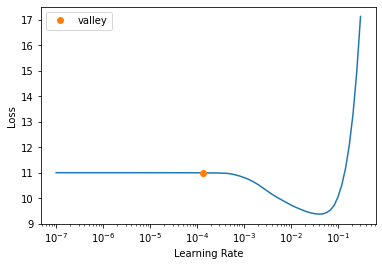

In [8]:
torch.cuda.empty_cache()
learn = language_model_learner(dls_lm, AWD_LSTM, pretrained=False, drop_mult=0.3,
                        metrics=[accuracy, Perplexity()]).to_fp16()
lr = 1e-2
lr *= bs/48  # scale learning rate by batch size.
learn.lr_find()  # For your curiosity. 

In [9]:
learn.unfreeze()
learn.fit_one_cycle(10, lr)  # make sure change this, this is just testing. 

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.491074,3.720917,0.332841,41.302250,14:10
1,3.549865,3.780953,0.324743,43.857803,14:11
2,3.457856,3.645890,0.339775,38.316849,14:10
3,3.370860,3.531587,0.350970,34.178169,14:13
4,3.295632,3.450127,0.360879,31.504381,14:14
5,3.219705,3.344408,0.373323,28.343792,14:14
6,3.112625,3.235554,0.384804,25.420444,14:11
7,3.022040,3.116740,0.399356,22.572672,14:15
8,2.983934,3.014831,0.412274,20.385653,14:12
9,2.924583,2.978534,0.417621,19.658970,14:14


In [20]:
save_path = Path(".")  # also change this with kaggle

mdl_path = path/"models"
mdl_path.mkdir(exist_ok=True)
learn.to_fp32().save(mdl_path/lm_fns[0], with_opt=False)
save_pickle(mdl_path/(lm_fns[1] + ".pkl"), learn.dls.vocab)

AttributeError: 'list' object has no attribute 'save'

We want to find baseline (someone using that to predict sentiment). Sentiment analysis dataset in Vietnamese, and someone whom would use that dataset to predict sentiment. It's difficult especially when in another language. Find for competitions if we need from the internet, and use Google Translate. We can find what score it displays, find for forum, e.g. 

## Vietnamese sentiment analysis

In [23]:
train_df = pd.read_csv(path/"sentiment/train.csv")
train_df.loc[pd.isna(train_df.comment), "comment"] = "NA"
train_df.head()

,id,comment,label
0,train_000000,Dung dc sp tot cam on \nshop Đóng gói sản phẩm rất đẹp và chắc chắn Chất lượng sản phẩm tuyệt vời,0
1,train_000001,Chất lượng sản phẩm tuyệt vời . Son mịn nhưng khi đánh lên không như màu trên ảnh,0
2,train_000002,Chất lượng sản phẩm tuyệt vời nhưng k có hộp k có dây giày đen k có tất,0
3,train_000003,:(( Mình hơi thất vọng 1 chút vì mình đã kỳ vọng cuốn sách khá nhiều hi vọng nó sẽ nói về việc học tập của cách sinh viên trường Harvard ra sao những nỗ lực của họ như thế nào 4h sáng? tại sao họ lại phải thức dậy vào thời khắc đấy? sau đó là cả một câu chuyện ra sao. Cái mình thực sự cần ở đây là câu chuyện ẩn dấu trong đó để tự bản thân mỗi người cảm nhận và đi sâu vào lòng người hơn. Còn cuốn sách này chỉ đơn thuần là cuốn sách dạy kĩ năng mà hầu như sách nào cũng đã có. BUồn...,1
4,train_000004,Lần trước mình mua áo gió màu hồng rất ok mà đợt này lại giao 2 cái áo gió chất khác như vải mưa ý :((,1


In [24]:
test_df = pd.read_csv(path/"sentiment/test.csv")
test_df.loc[pd.isna(test_df.comment), "comment"] = "NA"
test_df.head()

,id,comment
0,test_000000,Chưa dùng thử nên chưa biết
1,test_000001,Không đáng tiềnVì ngay đợt sale nên mới mua nhưng sp thì như đã qua sử dụng ! Đã nt trao đổi vs shop cũng đưa ra cách giải quyết nhưng kg được đổi hàng mà chỉ hoàn tiền !! Nên mình quyết định kg đổi hàng vì kg có time chỉ muốn đánh giá sp như những gì mình nhận được !
2,test_000002,Cám ơn shop. Đóng gói sản phẩm rất đẹp và chắc chắn
3,test_000003,Vải đẹp.phom oki luôn.quá ưng
4,test_000004,Chuẩn hàng đóng gói đẹp


In [25]:
df = pd.concat([train_df, test_df], sort=False)

In [26]:
dls_lm = DataBlock(
    blocks=TextBlock.from_df("comment", is_lm=True),
    get_items=ColReader("comment"), splitter=RandomSplitter(0.1)
).dataloaders(df, bs=bs, seq_len=72, num_workers=os.cpu_count())
dls_lm.show_batch(max_n=2)

,text,text_
0,xxbos k có giấy hướng dẫn sử dụng chưa dùng xxbos xxmaj thời gian giao hàng rất nhanh sp cũng tương đối xxbos xxmaj hàng y hình . xxmaj good xxbos đồng hồ rất đẹp mỗi tội dây hơi to xíu xxbos xxmaj nhìn thì ok . xxup mà khi dùng mỗi ngày phải lấy lại giờ 1 lần .. xxbos xxmaj thời gian giao hàng rất nhanh \n xxmaj rất,k có giấy hướng dẫn sử dụng chưa dùng xxbos xxmaj thời gian giao hàng rất nhanh sp cũng tương đối xxbos xxmaj hàng y hình . xxmaj good xxbos đồng hồ rất đẹp mỗi tội dây hơi to xíu xxbos xxmaj nhìn thì ok . xxup mà khi dùng mỗi ngày phải lấy lại giờ 1 lần .. xxbos xxmaj thời gian giao hàng rất nhanh \n xxmaj rất đáng
1,xxunk xxbos xxmaj không thấy tặng khẩu trang đâu cả xxbos xxmaj cái nào cũng ngon nha . \n xxmaj bánh xxunk mini xuất xxunk . \n xxmaj me cục bự chà bá :)) \n xxmaj cái nào cũng ngon lắm nha nha . xxbos áo dày dặn đẹp fom áo to nhưng hơi ngắn tý xxbos xxmaj giao sai màu đã ghi chú trong note đưa màu hồng để trên xe,xxbos xxmaj không thấy tặng khẩu trang đâu cả xxbos xxmaj cái nào cũng ngon nha . \n xxmaj bánh xxunk mini xuất xxunk . \n xxmaj me cục bự chà bá :)) \n xxmaj cái nào cũng ngon lắm nha nha . xxbos áo dày dặn đẹp fom áo to nhưng hơi ngắn tý xxbos xxmaj giao sai màu đã ghi chú trong note đưa màu hồng để trên xe hơi


/home/wabinab/anaconda3/envs/fastai/lib/python3.8/site-packages/fastai/callback/schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=tensor(0.0052))

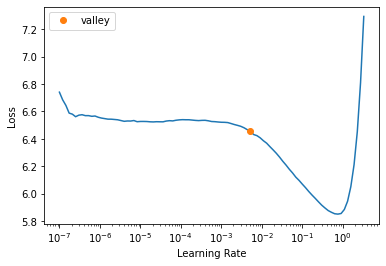

In [31]:
torch.cuda.empty_cache()
parent_lm_fns = [path/"models"/lmf for lmf in lm_fns]
learn_lm = language_model_learner(dls_lm, AWD_LSTM, pretrained_fnames=parent_lm_fns, drop_mult=1.0,
                                 metrics=accuracy)
learn_lm.lr_find()

In [32]:
lr = 1e-3
lr *= bs/48

learn_lm.fit_one_cycle(2, lr*10)

epoch,train_loss,valid_loss,time
0,4.781400,4.115162,00:15
1,4.312628,3.977977,00:12


In [33]:
learn_lm.unfreeze()
learn_lm.fit_one_cycle(8, lr)

epoch,train_loss,valid_loss,time
0,4.047122,3.870770,00:13
1,3.928577,3.750781,00:12
2,3.816829,3.682648,00:13
3,3.728614,3.632348,00:13
4,3.655899,3.603064,00:12
5,3.601605,3.589407,00:12
6,3.571414,3.582579,00:13
7,3.545113,3.582034,00:12


In [34]:
learn_lm.save(mdl_path/f"{lang}fine_tuned")
learn_lm.save_encoder(mdl_path/f"{lang}fine_tuned_enc")

In [73]:
save_pickle(mdl_path/f"vocab_1331.pkl", dls_lm.vocab)

# Classifier

In [74]:
dls_clas = DataBlock(
    blocks=(TextBlock.from_df("comment", vocab=dls_lm.vocab, seq_len=72), CategoryBlock),
    get_y=ColReader("label"), get_x=ColReader("text"), 
    splitter=RandomSplitter(0.1)
).dataloaders(train_df, bs=bs, num_workers=os.cpu_count())
dls_clas.show_batch(max_n=2)

,text,category
0,"xxbos xxmaj cuốn này mỏng . đọc một buổi sáng là hết . xxmaj thú thật nó làm tôi hơi thất vọng có thể vì tôi đã kì vọng hơi cao vào tác phẩm xxmaj hàn xxmaj quốc đầu tiên trong đời . xxmaj nhưng thôi tôi sẽ cố gắng nhận xét khách quan nhất có thể . \n xxmaj tuy đặt vào tình huống đau buồn - sau sự ra đi của một cậu học sinh mới mười sáu tuổi - nhưng xxmaj tôi đã chết vào một ngày nào đó không quá u ám nặng nề . xxmaj thay vì khai thác tột cùng nỗi đau và mất mát , tác giả cố gắng xxunk dịu nó , hàn gắn nó bằng những kí ức tươi đẹp , những suy tư giản dị , gần gũi và những tình cảm chân thành . xxmaj truyện kể theo lời",1
1,"xxbos xxmaj tôi thực sự không thích cuốn sách này . xxmaj tôi không thích nó cũng như tất cả những loại sách self - help ngày nay . xxup về cơ bản thì thông điệp của tác giả muốn nhắn gửi đến là : nếu bạn muốn làm một việc gì đó bạn hãy thực hiện nó hết sức mình không quan tâm đến những gì xung quanh không nghi ngờ gì về việc đó và trên hết không cần để ý đến những chỉ trích nhắm vào bạn . \t xxmaj tôi không đồng ý với quan điểm của tác giả không chỉ bởi vì quan điểm đó sai , mà bởi vì nó quá tệ . \n\t xxmaj nếu vì bạn đam mê một thứ gì đó , điều đó chưa chắc đã là tốt . xxmaj theo quan điểm của tôi , thông điệp “ đi",1


In [75]:
from sklearn.metrics import f1_score

@np_func
def f1(inp, targ): return f1_score(targ, np.argmax(inp, axis=-1))

Actually, we already have `f1_score` from fastai v2, however we will just use our own function to compare with v1 availability. 

/home/wabinab/anaconda3/envs/fastai/lib/python3.8/site-packages/fastai/callback/schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=tensor(0.0014))

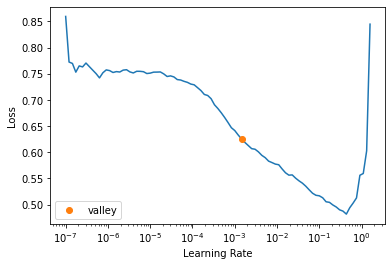

In [77]:
# metrics = [accuracy, f1_score]  # for using internal f1_score. 
learn_c = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, 
                metrics=[accuracy, f1]).to_fp16()
learn_c.load_encoder(mdl_path/f"{lang}fine_tuned_enc")
learn_c.freeze()
learn_c.lr_find()

In [78]:
lr = 2e-2
lr *= bs/48

learn_c.fit_one_cycle(2, lr)

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.341415,0.272112,0.883085,0.850911,00:07
1,0.310554,0.255690,0.893657,0.873131,00:07


In [79]:
learn_c.fit_one_cycle(2, lr)

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.353487,0.280958,0.886194,0.870291,00:07
1,0.322257,0.263252,0.895522,0.877343,00:07


In [80]:
learn_c.freeze_to(-2)
learn_c.fit_one_cycle(2, slice(lr/(2.6**4), lr))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.327982,0.325063,0.884328,0.869873,00:07
1,0.284454,0.226169,0.907338,0.885044,00:08


In [81]:
learn_c.freeze_to(-3)
learn_c.fit_one_cycle(2, slice(lr/2/(2.6**4), lr/2))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.249204,0.237454,0.912935,0.897215,00:07
1,0.202054,0.246352,0.902985,0.881268,00:08


In [82]:
learn_c.unfreeze()
learn_c.fit_one_cycle(1, slice(lr/10/(2.6**4), lr/10))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.161425,0.256219,0.898632,0.870422,00:08


In [83]:
learn_c.save(mdl_path/f"{lang}clas")

Path('/home/wabinab/.fastai/viwiki/models/viclas.pth')

# Ensemble

In [155]:
dls_clas = DataBlock(
    blocks=(TextBlock.from_df("comment", vocab=dls_lm.vocab, seq_len=72), CategoryBlock),
    get_y=ColReader("label"), get_x=ColReader("text"), 
    splitter=ColSplitter()
).dataloaders(train_df, bs=bs, num_workers=os.cpu_count(), shuffle=False)

In [156]:
learn_c = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, metrics=[accuracy, f1]).to_fp16()
learn_c.load(mdl_path/f"{lang}clas") #, purge=False)

In [157]:
preds, targs = learn_c.get_preds() #ordered=True)
accuracy(preds, targs), f1(preds, targs)

(TensorBase(0.9568), tensor(0.9491))

In [162]:
preds.shape

torch.Size([3217, 2])

In [159]:
vocab = load_pickle(mdl_path/f"{lang}_vocab_bwd.pkl")
dls_clas_bwd = DataBlock(
    blocks=(TextBlock.from_df("comment", vocab=vocab, backwards=True), CategoryBlock),
    get_x=ColReader("text"), get_y=ColReader("label"), 
    splitter=ColSplitter()
#     splitter=RandomSplitter(0.1)
).dataloaders(train_df, bs=bs, num_workers=os.cpu_count(), backwards=True, shuffle=False)
# dls_clas_bwd.show_batch(max_n=2)

In [160]:
dls_clas_bwd.shuffle = False
learn_c_bwd = text_classifier_learner(dls_clas_bwd, AWD_LSTM, drop_mult=0.5, metrics=[accuracy, f1]).to_fp16()
learn_c_bwd.load(mdl_path/f"{lang}clas_bwd") #, purge=False)

In [161]:
preds_b, targs_b = learn_c_bwd.get_preds() #ordered=True)
accuracy(preds_b, targs_b), f1(preds_b, targs_b)

(TensorBase(0.9030), tensor(0.8756))

In [163]:
preds_b.shape

torch.Size([3217, 2])

In [164]:
preds_avg = (preds + preds_b) / 2
accuracy(preds_avg, targs_b), f1(preds_avg, targs_b)

(TensorBase(0.9546), tensor(0.9458))

In [134]:
from sklearn.metrics import mean_squared_error
mean_squared_error(targs, targs_b)

0.44776119402985076

In [136]:
learn_c_bwd.get_preds(reorder=True)

(tensor([[0.9831, 0.0169],
         [0.4108, 0.5892],
         [0.4025, 0.5975],
         ...,
         [0.9974, 0.0026],
         [0.3464, 0.6536],
         [0.9976, 0.0024]]),
 TensorCategory([0, 1, 1,  ..., 0, 1, 0]))

In [137]:
learn_c.get_preds(reorder=True)

(tensor([[3.4549e-01, 6.5451e-01],
         [6.3948e-01, 3.6052e-01],
         [1.7813e-04, 9.9982e-01],
         ...,
         [9.9184e-01, 8.1562e-03],
         [9.8611e-01, 1.3889e-02],
         [9.0166e-01, 9.8339e-02]]),
 TensorCategory([0, 1, 1,  ..., 0, 0, 0]))

Note that this isn't a good method. The above method **is wrong**. Particularly, training are different. We should have fixed ` is_valid`  for training backwards classification model as well to get something that reflects the value. We'll leave it for here for those enthusiastic to fix it. 